<a href="https://colab.research.google.com/github/keiokosaka/Physical-AI-public/blob/main/physicalAI_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

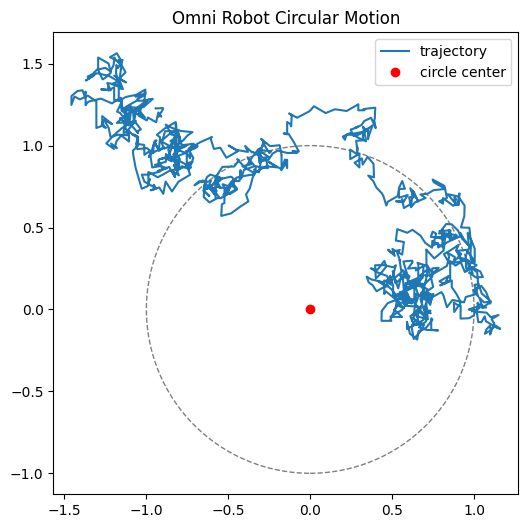

動画を保存しました: omni_simulation.mp4


In [3]:
!pip install stable-baselines3[extra] moviepy pybullet -q

# ライブラリ
# 必要ライブラリのインポート
import numpy as np
import pybullet as p
import pybullet_data
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import imageio
import os

# シミュレーション環境の定義
class OmniWheelEnv(gym.Env):
    def __init__(self, render_mode=False):
        super().__init__()
        self.render_mode = render_mode
        self.max_steps = 1000
        self.time_step = 1. / 240.
        self.step_counter = 0
        self.radius = 1.0  # 円弧の半径
        self.speed = 10.0  # ロボットの速さ（角速度 × 半径）
        self.omega = self.speed / self.radius  # 一定の角速度

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)

        if self.render_mode:
            p.connect(p.GUI)
        else:
            p.connect(p.DIRECT)

        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.8)
        self.plane = p.loadURDF("plane.urdf")
        self.robot = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)
        self.plane = p.loadURDF("plane.urdf")
        self.robot = p.loadURDF("r2d2.urdf", [1, 0, 0.1])  # 初期位置(1,0)
        self.step_counter = 0
        return self._get_obs(), {}

    def _get_obs(self):
        pos, orn = p.getBasePositionAndOrientation(self.robot)
        lin_vel, ang_vel = p.getBaseVelocity(self.robot)
        return np.array([*pos[:2], orn[2], *lin_vel[:2], ang_vel[2]], dtype=np.float32)

    def step(self, action):
        self.step_counter += 1

        # モーターの出力をシンプルに位置制御として反映
        wheel_matrix = np.array([
            [-np.sqrt(3)/2, 0.5, 1],
            [0, -1, 1],
            [np.sqrt(3)/2, 0.5, 1]
        ])
        vel = wheel_matrix.T @ action * self.speed
        vx, vy, omega = vel[0], vel[1], vel[2]

        # ボディに力を加える（簡易モデル）
        p.resetBaseVelocity(self.robot, linearVelocity=[vx, vy, 0], angularVelocity=[0, 0, omega])
        p.stepSimulation()

        obs = self._get_obs()
        x, y, _, _, _, _ = obs

        # 円の中心を原点に設定
        radius_error = np.sqrt(x**2 + y**2) - self.radius
        reward = -float(radius_error ** 2)
        terminated = False
        truncated = self.step_counter >= self.max_steps

        return obs, reward, terminated, truncated, {}

    def render(self):
        pass

    def close(self):
        p.disconnect()

# 環境作成と検証
env = OmniWheelEnv(render_mode=False)
check_env(env)

# 学習
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=50000)

# 学習したモデルでシミュレーション
env = OmniWheelEnv(render_mode=False)
obs, _ = env.reset()
frames = []
traj = []

for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    pos, _, = p.getBasePositionAndOrientation(env.robot)
    traj.append(pos[:2])

    # 画像取得
    view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 0.1], distance=3, yaw=90, pitch=-60, roll=0, upAxisIndex=2)
    proj_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1.0, nearVal=0.1, farVal=10.1)
    (_, _, px, _, _) = p.getCameraImage(320, 240, view_matrix, proj_matrix)
    img = np.reshape(px, (240, 320, 4))[:, :, :3]
    frames.append(img.astype(np.uint8))

    if terminated or truncated:
        break

# 動画保存
video_path = "omni_simulation.mp4"
imageio.mimsave(video_path, frames, fps=30)

# 学習結果の行列表示
actions = []
states = []
for _ in range(300):
    action, _ = model.predict(obs)
    obs, _, terminated, truncated, _ = env.step(action)
    states.append(obs[:3])  # x, y, θ
    actions.append(action)
    if terminated or truncated:
        break

actions = np.array(actions)
states = np.array(states)

pseudo_inverse = np.linalg.pinv(states)
matrix_estimate = pseudo_inverse @ actions
print("\n学習されたモーター制御行列:")
print(matrix_estimate)

# 経路描画
traj = np.array(traj)
plt.figure(figsize=(6, 6))
plt.plot(traj[:, 0], traj[:, 1], label="trajectory")
plt.plot(0, 0, "ro", label="circle center")
circle = plt.Circle((0, 0), env.radius, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.axis("equal")
plt.legend()
plt.title("Omni Robot Circular Motion")
plt.show()

print("動画を保存しました:", video_path)
